In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

%pip install -U -q git+https://github.com/facebookresearch/audiocraft#egg=audiocraft
%pip install -q mutagen
%pip install -q transformers
%pip install -q loguru
%pip install -q openai langchain langchain[docarray] tiktoken

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 10.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 M

In [13]:
import os
import sys

from rich.pretty import pprint

from audiocraft.models import musicgen
from audiocraft.utils.notebook import display_audio
from audiocraft.data.audio import audio_write

from mutagen.mp3 import MP3

from IPython.display import Audio

import torch

from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
class ImageDescriber:
    def __init__(self, model_name: str, device: str) -> None:
        self._device = device

        self._processor = BlipProcessor.from_pretrained(model_name)
        self._model = BlipForConditionalGeneration.from_pretrained(model_name).to(
            device
        )

    def __call__(self, image_path: str) -> str:
        image_obj = Image.open(image_path).convert("RGB")
        inputs = self._processor(image_obj, return_tensors="pt").to(self._device)
        output = self._model.generate(**inputs)
        return self._processor.decode(output[0], skip_special_tokens=True)

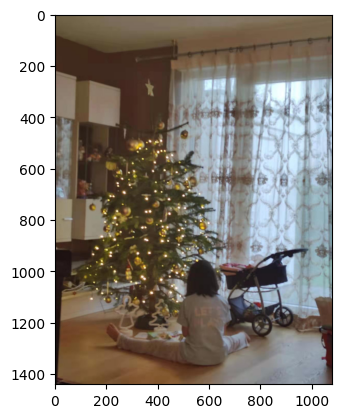

In [5]:
!wget -O xmasroom.jpeg https://dl.dropbox.com/scl/fi/5k3bjs98z6ubb9m5zkrwb/xmasroom.jpeg?rlkey=qlxud26eieqpk77frh47dch9g&dl=0

Image.open('xmasroom.jpeg').show()

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('xmasroom.jpeg')
plt.imshow(img)
plt.show()

In [6]:
image_describer = ImageDescriber("Salesforce/blip-image-captioning-base", device)
res_base = image_describer("xmasroom.jpeg")
res_base

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'a little girl sitting on the floor next to a christmas tree'

In [7]:
image_describer = ImageDescriber("Salesforce/blip-image-captioning-large", device)
res_large = image_describer("xmasroom.jpeg")
res_large

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

'there is a little girl sitting on the floor in front of a christmas tree'

In [14]:
openai_key = None
if 'google.colab' in sys.modules:
    from google.colab import userdata
    openai_key = userdata.get('OPENAI_API_KEY')
else:
    openai_key = os.environ['OPENAI_API_KEY']

In [27]:
prompt = ChatPromptTemplate.from_template(
    """Take the next sentence and enrich it with details, keep it compact:

    {context}

    Tunes invokes the feeling of environment that the sentence has. The enriched details
    can prompt for a music generation model for generating music from text.
    """
)
model = ChatOpenAI(openai_api_key=openai_key, max_tokens=100)
output_parser = StrOutputParser()

chain = prompt | model | output_parser

res = chain.invoke({"context": res_large})
res

'A wide-eyed little girl, no more than five years old, sits cross-legged on the plush carpet, her tiny hands gripping tightly onto a worn teddy bear. Before her, a majestic Christmas tree stands tall, adorned with twinkling lights, shimmering ornaments, and delicate tinsel that glimmers in the soft glow of the room. The air is filled with the warm scent of cinnamon and freshly baked cookies, while the gentle crackling of the fireplace adds a cozy ambiance.'

In [31]:
model = musicgen.MusicGen.get_pretrained('medium', device=device)
model.set_generation_params(duration=15)

/usr/local/lib/python3.10/dist-packages/audiocraft/models/musicgen.py:127: UserWarning: MusicGen pretrained model relying on deprecated checkpoint mapping. Please use full pre-trained id instead: facebook/musicgen-medium
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [32]:
musicgen_out = model.generate([res], progress=True)

In [34]:
display_audio(musicgen_out, sample_rate=32000)